In [186]:
# Merge Sort for Dummies
# Here I implement a Merge Sort
# algorithm, which utilizes recursion,
# and generate lots of fun animations 
# to demonstrate the process.
# Matt Spencer - DataBard
# www.databard.blog
# 4/18/2018
library("databaRd")
library("ggplot2")
library("dplyr")
library("gganimate")
library("animation")
library("png")
library("gridExtra")

In [44]:
# Here two sorted vectors are merged into a
# longer sorted vector.
merge.vs <- function(v1, v2) {
    v.merge <- numeric()
    idx <- 1
    while (length(v1) > 0 | length(v2) > 0) {
        if (length(v1) == 0)      { v.merge <- c(v.merge, v2); break }
        else if (length(v2) == 0) { v.merge <- c(v.merge, v1); break }
        else if (v1[1] < v2[1])   { v.merge[idx] <- v1[1]; v1 <- v1[-1] } 
        else                      { v.merge[idx] <- v2[1]; v2 <- v2[-1] }
        idx <- idx + 1
    }
    return(v.merge)
}

# This function splits an unsorted vector in half, and 
# and calls itself (recursively) to sort each half. Then
# the sorted halves are merged into a larger sorted vector.
merge.sort.vectors <- function(v) {
    n <- length(v)
    if (n == 1) return(v)
    sorted <- merge.vs(merge.sort(v[1:floor(n/2)]), merge.sort(v[(floor(n/2)+1):n]))
    return(sorted)
}

v1 <- sample(1:30)
merge.sort.vectors(v1)

[1] 20 16  2 18 13  9 29  3 28  4 11 10 14 22 26  5 19 25  7  1 30  6 15 12 27
[26]  8 17 24 21 23

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30

In [185]:
# Global variables are used to store the data needed to 
# print the frames of the animation. These global variables
# are initiated here.
all <- c()
data <- data.frame(rank = numeric(), value = numeric(), frame = numeric())
rects <- data.frame(xmin = numeric(), xmax = numeric(), ymin = numeric(), ymax = numeric(), 
                    type = factor(c(), levels = c("m", "v1", "v2")), frame = numeric())

# Quick handling of the case where min or max is 
# calculated on an empty vector
vmin <- function(v) if (length(v) == 0) Inf else min(v)
vmax <- function(v) if (length(v) == 0) Inf else max(v)

# Here the global variables are updated to include information
# for the next frame of the animation.
add.data <- function(v, m = numeric(), v1 = numeric(), v2 = numeric()) {
    f <- 1
    if(nrow(data) > 0) f <- max(data$frame) + 1
    newdata <- data.frame(rank = 1:length(v), value = v, frame = f)
    newrects <- data.frame(xmin = c(vmin(m), vmin(v1), vmin(v2)) - 0.47,
                        xmax = c(vmax(m), vmax(v1), vmax(v2)) + 0.47,
                        ymin = -1, ymax = max(v) + 1,
                        type = factor(c("m", "v1", "v2"), levels = c("m", "v1", "v2")),
                        frame = f) %>%
               filter(xmin != Inf)
    data <<- rbind(data, newdata)
    rects <<- rbind(rects, newrects)
}

# r1 and r2 indicate two ranges of indexes
# that refer to the global variable "all".
# These are the two sections of the list that
# will be sorted next.
merge.ranges <- function(r1, r2) {
    merged <- numeric()
    while (length(r1) > 0 | length(r2) > 0) {
        add.data(all, merged, r1, r2)
        
        # These first two conditions here should really just add the remainder of the
        # only vector with any data in it to the end of the merged list. Here I had it
        # add one at a time so that a new frame of the animation could be generated for
        # each of these steps.
        if (length(r1) == 0)              { merged <- c(merged, r2[1]); r2 <- r2[-1] }
        else if (length(r2) == 0)         { merged <- c(merged, r1[1]); r1 <- r1[-1] }
        else if (all[r1[1]] < all[r2[1]]) { merged <- c(merged, r1[1]); r1 <- r1[-1] }
        else { 
            t <- all[r2[1]] 
            all[r1 + 1] <<- all[r1]
            all[r1[1]] <<- t
            merged <- c(merged, r1[1])
            r1 <- r1 + 1
            r2 <- r2[-1]
        }
    }
    add.data(all, merged)
    return(merged)
}

# This function splits an unsorted vector in half, and 
# and calls itself (recursively) to sort each half. Then
# the sorted halves are merged into a larger sorted vector.
recurse.merge.sort <- function(range = 1:length(all)) {
    n <- length(range)
    if(n == 1) return(range) 
    sorted <- merge.ranges(recurse.merge.sort(range[1:floor(n/2)]), recurse.merge.sort(range[(floor(n/2)+1):n]))
    return(sorted)
}

# Wrapper function for the merge sort, which is only
# necessary due to the need for saving data for the 
# animation. Global variables are reset, and the 
# sorting algorithm is launched.
merge.sort <- function(v) {
    all <<- v
    data <<- data.frame(rank = numeric(), value = numeric(), frame = numeric())
    rects <<- data.frame(xmin = numeric(), xmax = numeric(), ymin = numeric(), ymax = numeric(), 
                         type = factor(c(), levels = c("m", "v1", "v2")), frame = numeric())
    add.data(all)
    x <- recurse.merge.sort()
    return(all)
}

In [183]:
# This function duplicates the blocks in the first
# frame multiple times, effectively elongating the
# length of the first frame
extend.first <- function(df, times) {
    f <- min(df$frame)
    first.frame <- df[df$frame == f,]

    newrows <- first.frame
    for (i in 1:times) {
        first.frame$frame <- f + i
        newrows <- rbind(newrows, first.frame)
    }
    df <- mutate(df, frame = frame + times + 1)

    return(rbind(newrows, df))
}                                                                

# Like extend.first, but for the final frame 
extend.last <- function(df, times) {
    f <- max(df$frame)
    last.frame <- df[df$frame == f,]

    for (i in 1:times) {
        last.frame$frame <- f + i
        df <- rbind(df, last.frame)
    }
    return(df)
}                                           

# This function takes the block data and the rectangles
# and plots them into a series of frames, finally arranging
# them into an animation using gganimate.
plot.animation <- function(d, r, fname = "figures/mymerge.gif", col.low = "light green", col.high = "dark green", color.only = F,
                           num.first = 0, num.last = 0) {
    if (num.first > 0) d <- extend.first(d, num.first)
    if (num.first > 0) r <- mutate(r, frame = frame + num.first + 1)
    if (num.last > 0) d <- extend.last(d, num.last)
    
    img <- readPNG("~/DataBard/logos/icon.png")
    logo <- rasterGrob(img, interpolate=TRUE)
    
    g <- ggplot(d, aes(x = rank, y = value, fill = value, frame = frame)) +
        annotation_custom(logo, xmin = 0, xmax = max(data$rank)/20, ymin = max(d$value) * 9/10 + 1, ymax = max(d$value) + 1) +
        geom_col(width = 1, position = "identity") +
        geom_rect(data = r, alpha = 0, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax, color = type,
                                               x = NULL, y = NULL, fill = NULL)) +
        scale_x_continuous(limits = c(-1, max(d$rank) + 1), expand = c(0,0)) +
        scale_y_continuous(limits = c(-1, max(d$value) + 1), expand = c(0,0)) +
        scale_fill_gradient(low = col.low, high = col.high) +
        scale_color_manual(values=c("blue", "red", "red")) +
        guides(fill=F, color=F) +
        theme_databard() +
        theme(
            text = element_blank(),
            axis.line = element_blank(), 
            axis.ticks = element_blank(),
            panel.background = element_blank(),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.background = element_blank()
        )
    
    if (color.only) g <- g + geom_col(aes(y = max(v)), width = 1, position = "identity")
    
    gganimate(g, filename = fname, ani.width=600, ani.height=300)
}

In [141]:
# This function plots a single frame of the blocks and 
# (optionally) rectangles
plot.vector <- function(v, dir = "", col.low = "light green", col.high = "dark green", color.only = F,
                        m = numeric(), v1 = numeric(), v2 = numeric()) {
    img <- readPNG("~/DataBard/logos/icon.png")
    logo <- rasterGrob(img, interpolate=TRUE)
    
    data <- data.frame(rank = 1:length(v), value = v)
    g <- ggplot(data, aes(x = rank, y = value, fill = value)) +
        #annotation_custom(logo, xmin = 0, xmax = max(data$rank)/10, ymin = max(v) - max(v)/5 + 1, ymax = max(v) + 1) +
        geom_col(width=1) +
        scale_x_continuous(limits = c(-1, max(data$rank) + 1), expand = c(0,0)) +
        scale_y_continuous(limits = c(-1, 101), expand = c(0,0)) +
        scale_fill_gradient(low = col.low, high = col.high) +
        guides(fill=F) +
        theme_databard() +
        theme(
            text = element_blank(),
            axis.line = element_blank(), 
            axis.ticks = element_blank(),
            panel.background = element_blank(),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.background = element_blank()
        )
    
    if (length(m) > 0) g <- g + geom_rect(xmin = min(m) - 0.47, xmax = max(m) + 0.47, ymin = -1, ymax = max(v) + 1, 
                                          alpha=0, color="blue")
    if (length(v1) > 0) g <- g + geom_rect(xmin = min(v1) - 0.47, xmax = max(v1) + 0.47, ymin = -1, ymax = max(v) + 1, 
                                          alpha=0, color="red")
    if (length(v2) > 0) g <- g + geom_rect(xmin = min(v2) - 0.47, xmax = max(v2) + 0.47, ymin = -1, ymax = max(v) + 1, 
                                          alpha=0, color="red")
    
    if (color.only) g <- g + geom_col(aes(y = max(v)), width=1)
        
    if (dir != "") {
        fs <- list.files(dir)
        tag <- 1
        if (length(fs) > 0) tag <- max(as.numeric(lapply(sapply(fs, function(x) strsplit(x, "\\.")), '[[', 1))) + 1
        cat("Printing #", tag, "\n")
        fname <- paste(dir, "/", tag, ".sortplot.png", sep='')
        ggsave(file = fname, g, dpi = 100)
    }
    g
}

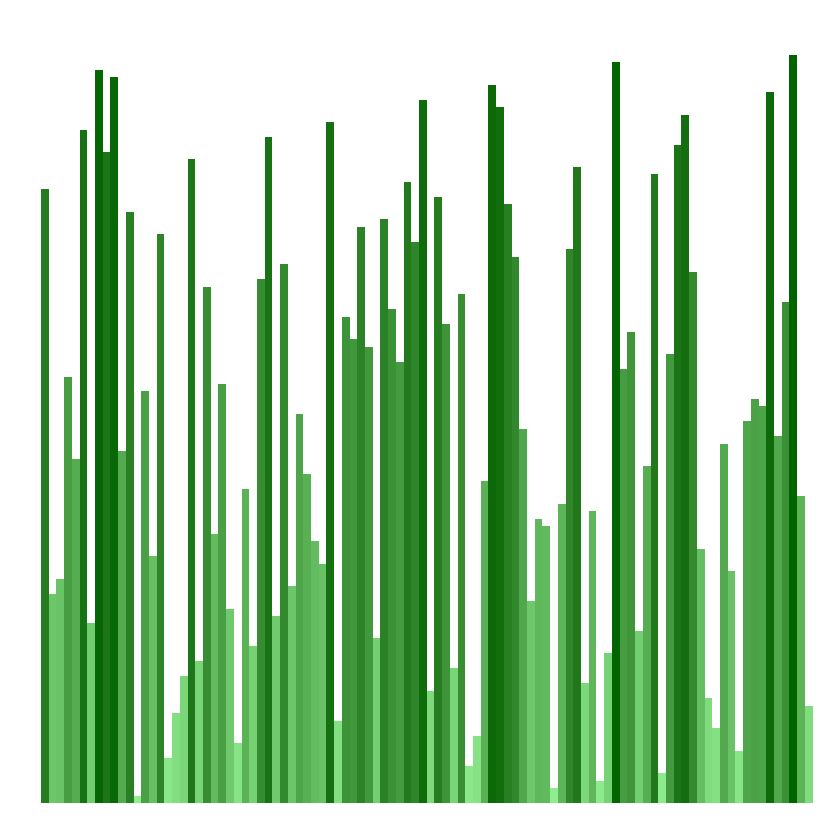

In [136]:
set.seed(98765)
ov <- sample(1:100)
p1 <- plot.vector(ov, color.only=F)
p1
fname <- "figures/01.unsorted.png"
ggsave(p1, filename = fname, width = 3, height = 1.5)

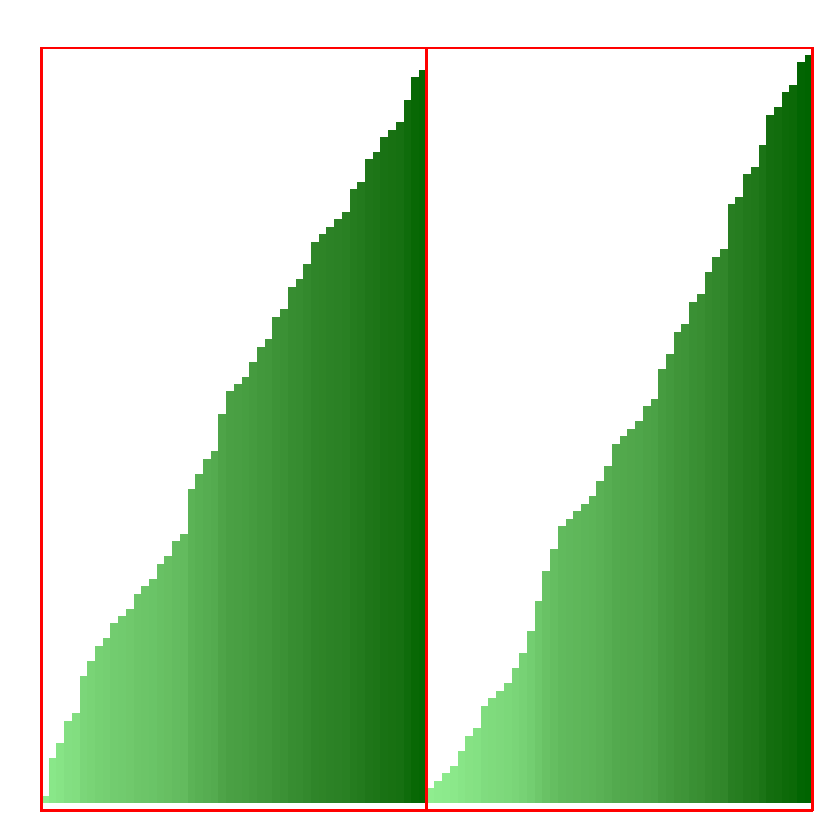

In [137]:
p <- plot.vector(c(merge.sort(ov[1:50]), merge.sort(ov[51:100])), color.only=F, v1=1:50, v2=51:100)
p
fname <- "figures/02.sortedhalves.png"
ggsave(p, filename = fname, width = 3, height = 1.5)

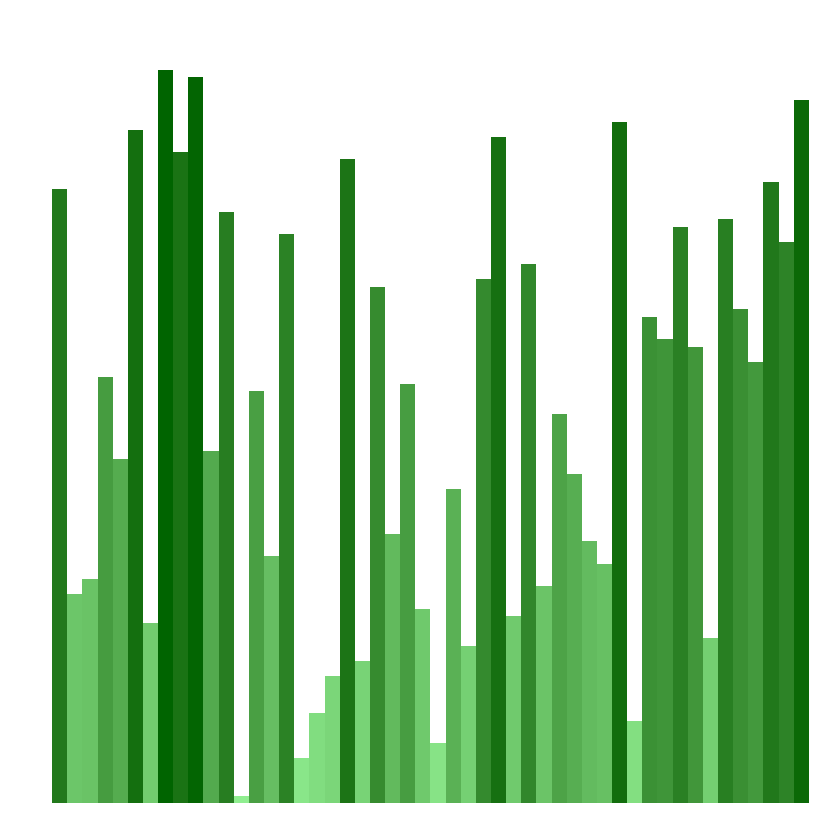

In [142]:
depth <- 1
n <- ceiling(length(ov)/(2**depth))
p <- plot.vector(ov[1:n], color.only=F)
p
fname <- "figures/03.unsorted.half.png"
ggsave(p, filename = fname, width = 3, height = 1.5)

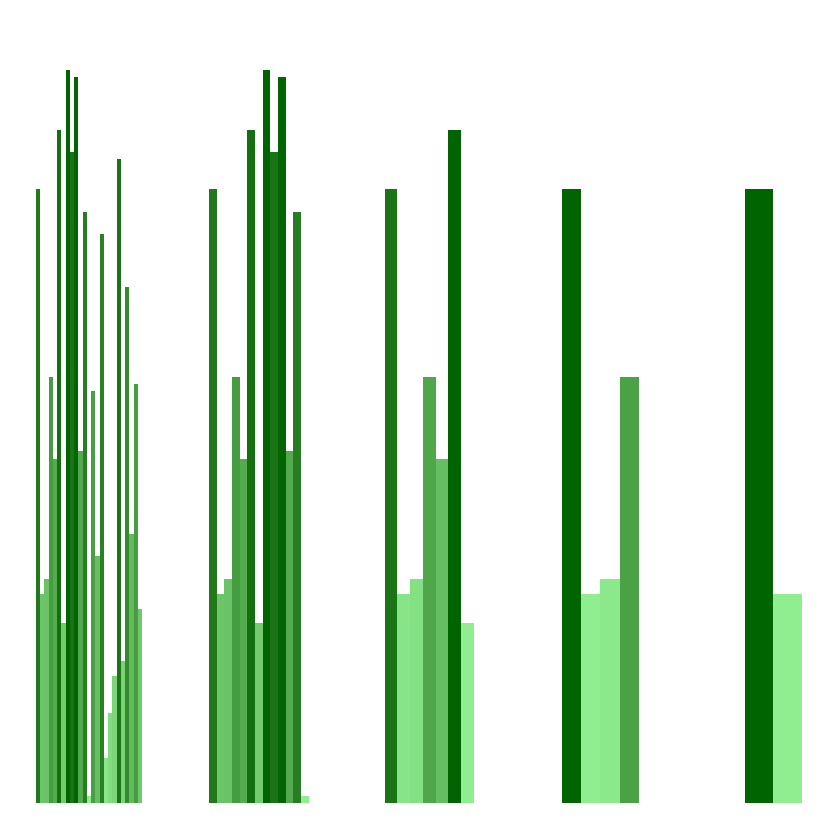

In [143]:
depth <- 2
n <- ceiling(length(ov)/(2**depth))
p2 <- plot.vector(ov[1:n], color.only=F)

depth <- 3
n <- ceiling(length(ov)/(2**depth))
p3 <- plot.vector(ov[1:n], color.only=F)

depth <- 4
n <- ceiling(length(ov)/(2**depth))
p4 <- plot.vector(ov[1:n], color.only=F)

depth <- 5
n <- ceiling(length(ov)/(2**depth))
p5 <- plot.vector(ov[1:n], color.only=F)

depth <- 6
n <- ceiling(length(ov)/(2**depth))
p6 <- plot.vector(ov[1:n], color.only=F)

g <- grid.arrange(p2, p3, p4, p5, p6, nrow = 1)
fname <- "figures/04.unsorted.2to6.png"
ggsave(g, filename = fname, width = 6, height = 1.5)

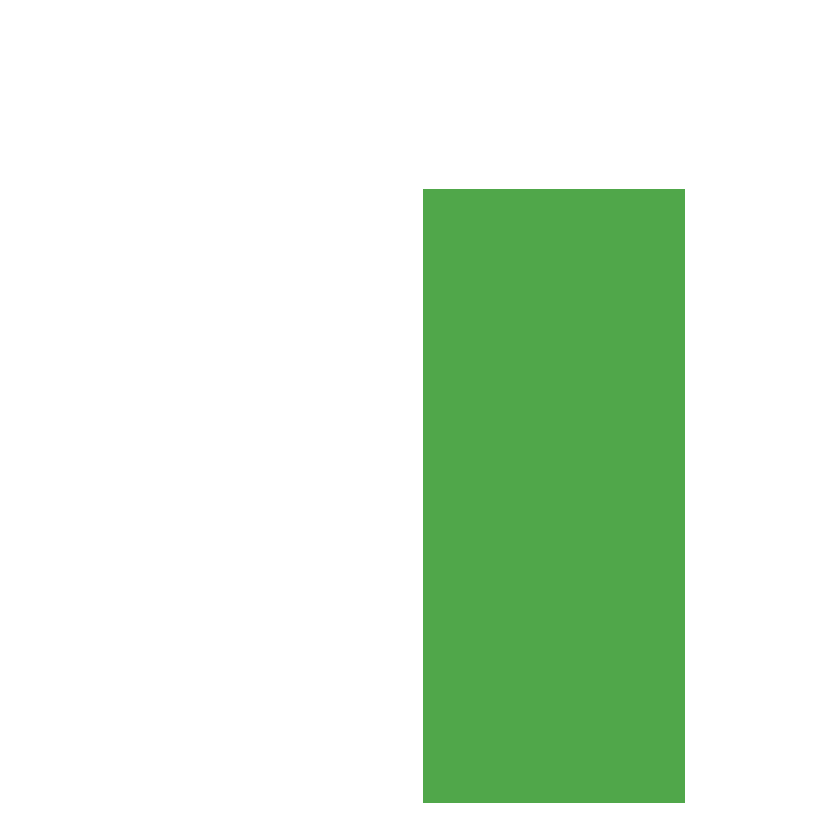

In [144]:
depth <- 7
n <- ceiling(length(ov)/(2**depth))
p <- plot.vector(ov[1:n], color.only=F)
p
fname <- "figures/05.single.png"
ggsave(p, filename = fname, width = 3, height = 1.5)

In [155]:
fname <- "figures/06.sort2.gif"
merge.sort(v[1:2])
ani.options(interval = 0.75)
plot.animation(data, rects, fname = fname, num.first = 0, num.last = 1)

[1] 28 82

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 75 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png '06.sort2.gif'
Output at: 06.sort2.gif


In [171]:
frame.full.span <- function(r, mx) {
    r <- filter(r, type %in% c("v1", "v2"))
    m <- merge(r, r, by="frame") %>%
        filter(type.x != type.y, xmax.y - xmin.x > mx * 0.8) %>%
        head(1) %>%
        .$frame
    return(m)
}

[1] 8

In [173]:
fname <- "figures/07.sort4.gif"
sub <- ov[1:4]
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.5)
plot.animation(data, rects, fname = fname, num.first = 0, num.last = 1)

[1] 28 30 57 82

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 50 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png '07.sort4.gif'
Output at: 07.sort4.gif


In [176]:
fname <- "figures/08.sort7.gif"
sub <- ov[1:7]
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.3)
plot.animation(data, rects, fname = fname, num.first = 1, num.last = 3)

[1] 24 28 30 46 57 82 90

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 30 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png '08.sort7.gif'
Output at: 08.sort7.gif


In [178]:
fname <- "figures/09.sort13.gif"
sub <- ov[1:13]
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.1)
plot.animation(data, rects, fname = fname, num.first = 3, num.last = 10)

[1]  1 24 28 30 46 47 57 79 82 87 90 97 98

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 10 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png '09.sort13.gif'
Output at: 09.sort13.gif


In [179]:
fname <- "figures/10.sort25.gif"
sub <- ov[1:25]
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.1)
plot.animation(data, rects, fname = fname, num.first = 3, num.last = 10)

[1]  1  6 12 17 19 24 26 28 30 33 36 46 47 55 56 57 69 76 79 82 86 87 90 97 98

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 10 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    '10.sort25.gif'
Output at: 10.sort25.gif


In [180]:
fname <- "figures/11.sort50.gif"
sub <- ov[1:50]
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.1)
plot.animation(data, rects, fname = fname, num.first = 3, num.last = 10)

[1]  1  6  8 11 12 17 19 21 22 24 25 26 28 29 30 32 33 35 36 42 44 46 47 52 55
[26] 56 57 59 61 62 65 66 69 70 72 75 76 77 78 79 82 83 86 87 89 90 91 94 97 98

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 10 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    Rplot41.png Rplot42.png Rplot43.png Rplot44.png Rplot45.png
    Rplot46.png Rplot47.png Rplot48.png Rplot49.png Rplot50.png
    Rplot51.png Rplot52.png Rplot53.png Rplot54.png Rplot55.png
    Rplot56.png Rplot57.png Rplot58.png Rplot59.png Rplot60.png
    Rplot61.png Rplot62.png Rplot63.png Rplot64.png Rplot65.png
    '11.sort50.gif'
Output at: 11.sort50.gif


In [181]:
fname <- "figures/12.sort100.gif"
sub <- ov
merge.sort(sub)

f <- frame.full.span(rects, length(sub))
rects <- filter(rects, frame >= f) %>%
    mutate(frame = frame - f + 1)
data <- filter(data, frame >= f) %>%
    mutate(frame = frame - f + 1)

ani.options(interval = 0.1)
plot.animation(data, rects, fname = fname, num.first = 3, num.last = 10)

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 10 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    Rplot41.png Rplot42.png Rplot43.png Rplot44.png Rplot45.png
    Rplot46.png Rplot47.png Rplot48.png Rplot49.png Rplot50.png
    Rplot51.png Rplot52.png Rplot53.png Rplot54.png Rplot55.png
    Rplot56.png Rplot57.png Rplot58.png Rplot59.png Rplot60.png
    Rplot61.png Rplot62.png Rplot63.png Rplot64.png Rplot65.png
    Rplot66.png Rplot67.png Rplot68.png Rplot69.png Rplot70.png
    Rplot71.png Rplot72.png

In [184]:
fname <- "figures/merge100.gif"
merge.sort(ov)
ani.options(interval = 0.06)
plot.animation(data, rects, fname = fname, num.first = 10, num.last = 10)

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100

Warning message:
"Ignoring unknown aesthetics: x, y"Executing: 
convert -loop 0 -delay 6 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    Rplot41.png Rplot42.png Rplot43.png Rplot44.png Rplot45.png
    Rplot46.png Rplot47.png Rplot48.png Rplot49.png Rplot50.png
    Rplot51.png Rplot52.png Rplot53.png Rplot54.png Rplot55.png
    Rplot56.png Rplot57.png Rplot58.png Rplot59.png Rplot60.png
    Rplot61.png Rplot62.png Rplot63.png Rplot64.png Rplot65.png
    Rplot66.png Rplot67.png Rplot68.png Rplot69.png Rplot70.png
    Rplot71.png Rplot72.png 

Output at: merge100.gif
